# Frozen Lake: Reinforcement Learning

In [1]:
from ReinforcementLearning import *
%matplotlib notebook

## Deterministic case 

### Q-Learning 

In [2]:
env = FrozenLake.make(is_slippery=False)

In [3]:
strategy = QLearning(num_of_episodes=500,
                     policy=UniformRandomPolicy(env), 
                     learning_rate=1.0, 
                     decay_rate=0.01,
                     gamma=0.95,  # default value is 1.0
                     epsilon_min=0.01,  # is default value
                     epsilon_max=1.0)  # is default value

In [4]:
agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


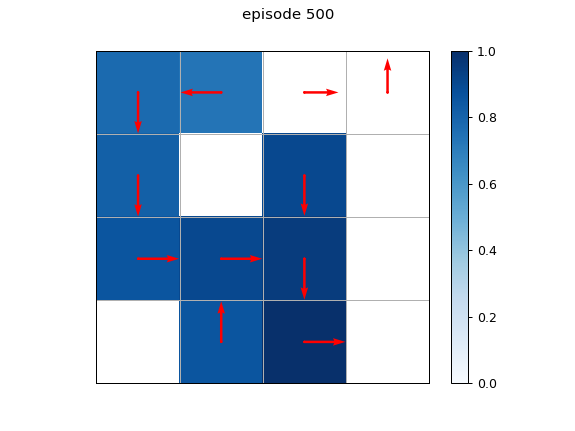

In [5]:
agent.learn(plot_frequency=50)

### Monte Carlo 

In [6]:
strategy = MonteCarlo(num_of_episodes=500,
                      policy=UniformRandomPolicy(env), 
                      learning_rate=1.0, 
                      decay_rate=0.01,
                      gamma=0.95)
agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


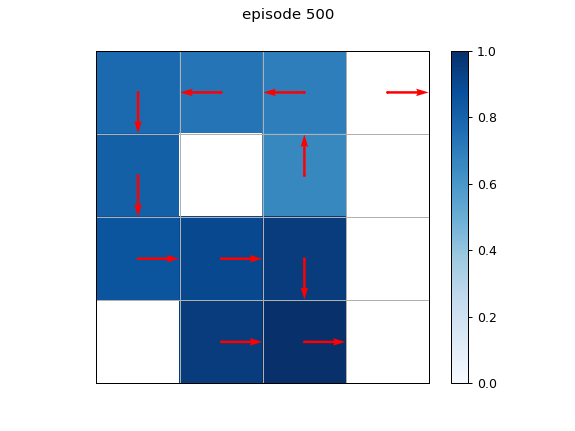

In [7]:
agent.learn(plot_frequency=50)

### N-Step Q-Learning 

In [8]:
strategy = NStepQLearning(num_of_episodes=500,
                          policy=UniformRandomPolicy(env), 
                          learning_rate=1.0,
                          Nstep=4,
                          decay_rate=0.01,
                          gamma=0.95)
agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


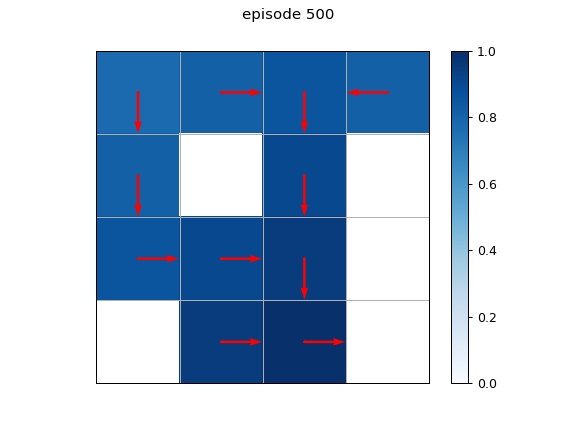

In [9]:
agent.learn(plot_frequency=50)

### Value Iteration 

In [10]:
strategy = ValueIteration(num_of_episodes=500,
                          policy=UniformRandomPolicy(env), 
                          decay_rate=0.01,
                          gamma=0.95)
agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


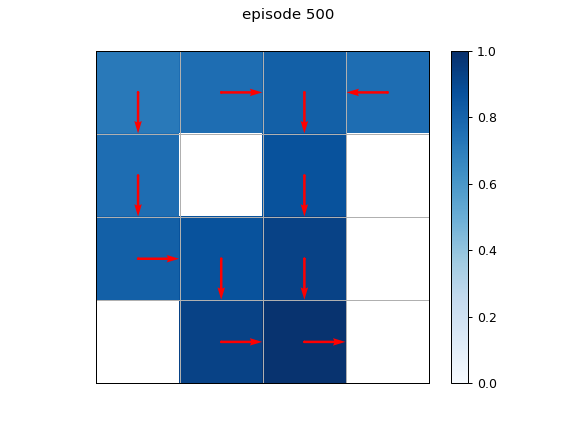

In [11]:
agent.learn(plot_frequency=50)

## Stochastic case 

### Q-Learning 

In [6]:
env = FrozenLake.make(is_slippery=True)

In [15]:
strategy = QLearning(num_of_episodes=500,
                     policy=UniformRandomPolicy(env), 
                     learning_rate=0.7,
                     decay_rate=0.01,
                     gamma=1.0)
agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


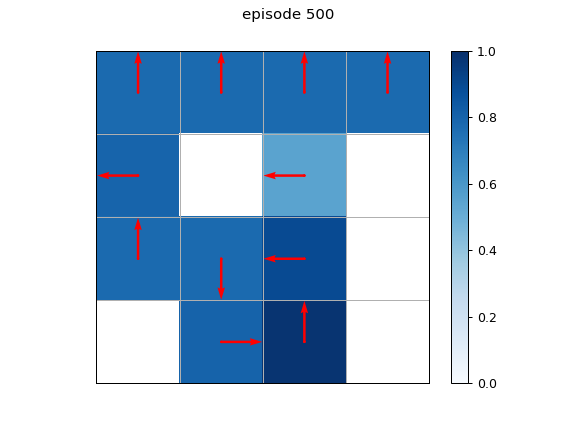

In [16]:
agent.learn(plot_frequency=50)

### Monte Carlo 

In [15]:
strategy = MonteCarlo(num_of_episodes=1000,
                      policy=UniformRandomPolicy(env), 
                      learning_rate=0.5,
                      decay_rate=0.01,
                      gamma=0.95)
agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


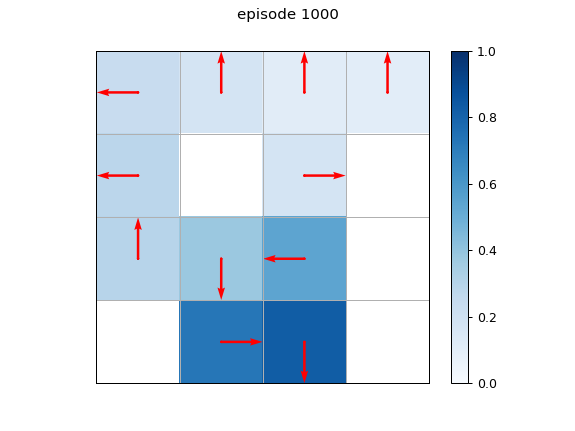

In [16]:
agent.learn(plot_frequency=50)

### N-Step Q-Learning 

In [17]:
strategy = MonteCarlo(num_of_episodes=1000,
                      policy=UniformRandomPolicy(env), 
                      learning_rate=0.5,
                      decay_rate=0.01,
                      gamma=0.95)
agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


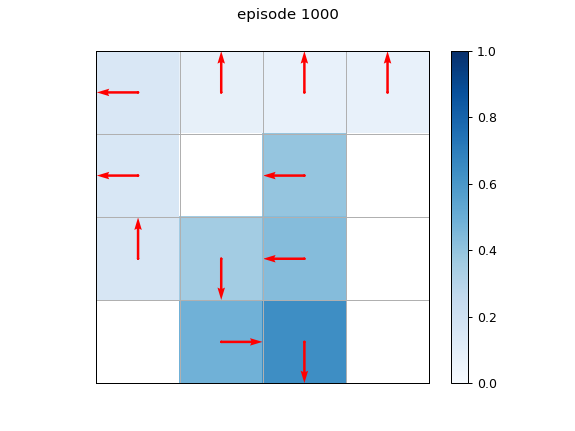

In [18]:
agent.learn(plot_frequency=50)

### Value Iteration

In [24]:
strategy = ValueIteration(num_of_episodes=500,
                          policy=UniformRandomPolicy(env), 
                          decay_rate=0.01,
                          gamma=1.0)
agent = Agent(env, strategy)

In [27]:
print(np.reshape(strategy.Vs, (4, 4), order="c"))
print(strategy.Qsa)

[[0.19624334 0.17304781 0.15797484 0.15300065]
 [0.20380105 0.         0.12431949 0.        ]
 [0.21987344 0.24408307 0.24971005 0.        ]
 [0.         0.47733322 0.73792132 0.        ]]
[[0.19876333 0.18963688 0.19034967 0.18825799]
 [0.13583982 0.13310554 0.13040286 0.17524897]
 [0.15516038 0.14921141 0.1486777  0.15998139]
 [0.09270946 0.0621951  0.03060013 0.15494369]
 [0.20641793 0.15067453 0.14394068 0.14026746]
 [0.         0.         0.         0.        ]
 [0.03949371 0.04994201 0.12585489 0.05265828]
 [0.         0.         0.         0.        ]
 [0.15572593 0.15269032 0.16888028 0.22230379]
 [0.24686383 0.2273326  0.22072618 0.15652783]
 [0.16424068 0.         0.25276238 0.12330706]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.24098795 0.11933331 0.48300965 0.31304935]
 [0.49381569 0.74715575 0.6926948  0.24971005]
 [0.         0.         0.         0.        ]]


In [28]:
print(strategy.policy.prob)

[[0.98744679 0.0041844  0.0041844  0.0041844 ]
 [0.0041844  0.0041844  0.0041844  0.98744679]
 [0.0041844  0.0041844  0.0041844  0.98744679]
 [0.0041844  0.0041844  0.0041844  0.98744679]
 [0.98744679 0.0041844  0.0041844  0.0041844 ]
 [0.0041844  0.0041844  0.0041844  0.98744679]
 [0.0041844  0.0041844  0.98744679 0.0041844 ]
 [0.0041844  0.0041844  0.98744679 0.0041844 ]
 [0.0041844  0.0041844  0.0041844  0.98744679]
 [0.98744679 0.0041844  0.0041844  0.0041844 ]
 [0.0041844  0.0041844  0.98744679 0.0041844 ]
 [0.98744679 0.0041844  0.0041844  0.0041844 ]
 [0.0041844  0.98744679 0.0041844  0.0041844 ]
 [0.0041844  0.0041844  0.98744679 0.0041844 ]
 [0.0041844  0.98744679 0.0041844  0.0041844 ]
 [0.0041844  0.0041844  0.0041844  0.98744679]]


<IPython.core.display.Javascript object>


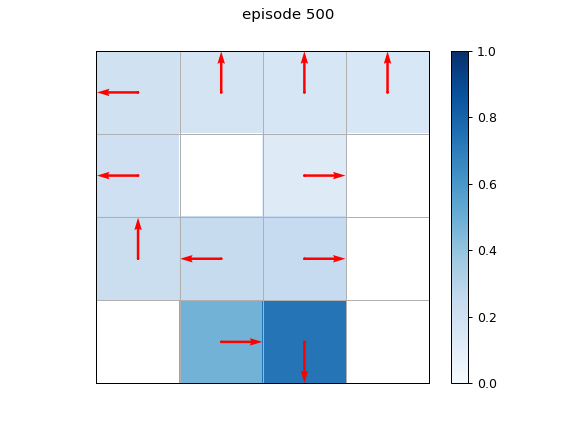

In [25]:
agent.learn(plot_frequency=50)

In [21]:
policy = strategy.mdp.policy_improvement(strategy.Vs)

<IPython.core.display.Javascript object>


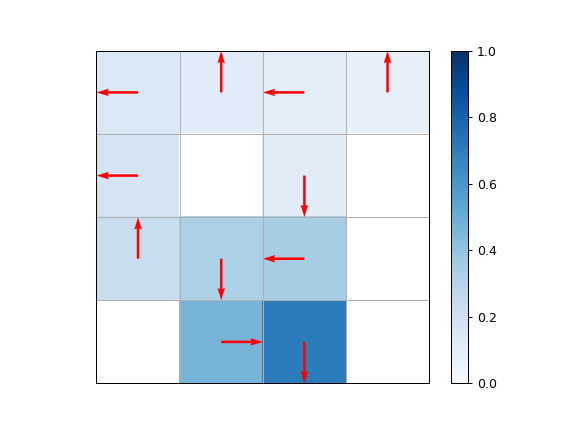

In [22]:
env.plot(values=strategy.Vs, policy=policy)

In [18]:
import matplotlib
matplotlib.get_backend()

'nbAgg'